## Computer vision 2022 Assignment 3: Deep Learning for Perception Tasks

This assignment contains 2 questions. The first question gives you a basic understanding of the classifier. The second question requires you to write a simple proposal.

# Question 1: A simple classifier (60%)

For this exercise, we will provide a demo code showing how to train a network on a small dataset called FashionMinst. Please go through the following tutorials first. You will get a basic understanding about how to train an image classification network in pytorch. You can change the training scheme and the network structure. Please answer the following questions then. You can orginaze your own text and code cell to show the answer of each questions.


Note: Please plot the loss curve for each experiment (2 point).


Requirement:

Q1.1 (1 point) Change the learning rate and train for 10 epochs. Fill this table:

|Lr|Accuracy|
|---|---|
|1   |   19.92%   |
|0.1|     87.22%     |
|0.01|     83.67%    |
|0.001  |    87.5%    |


Q1.2 (2 point) Report the number of epochs when the accuracy reaches 90%. Fill this table:

|Lr|Accuracy|Epoch|
|---|---|---|
|1   |   10%   |   11  |
|0.1|     90%     |  174  |
|0.01|    89.04%     |  273  |
|0.001  |    87.2%    |   297  |


Q1.3 (2 points) Compare the results in table 1 and table 2, what is your observation and your understanding of learning rate?

From the table 1 and table 2, I notice that smaller learning rates necessitate more training epochs because of the fewer changes. On the other hand, larger learning rates result in faster changes.

Q1.4 (3 point) Build a deeper/ wider network. Report the accuracy and the parameters for each structure. Parameters represent the number of trainable parameters in your model, e.g. a 3 x 3 conv has 9 parameters.

|Structures|Accuracy|Parameters|
|---|---|---|
|Base   |   87.22%   |  669,706|
|Deeper|  89.4%        |   674,836|
|Wider|    90.3%     |   1,863,690|


Q1.5 (2 points) Choose to do one of the following two tasks:

a. Write a code to calculate the parameter and expian the code.

OR

b. Write done the process of how to calculate the parameters by hand. 


Q1.6 (1 points) What are your observations and conclusions for changing network structure?

With the increasing of the parameters, the accuracy will also increase.

Q1.7 (2 points) Calculate the mean of the gradients of the loss to all trainable parameters. Plot the gradients curve for the first 100 training steps. What are your observations? Note that this gradients will be saved with the training weight automatically after you call loss.backwards(). Hint: the mean of the gradients should be decreased.

For more exlanation of q1.7, you could refer to the following simple instructions: https://colab.research.google.com/drive/1XAsyNegGSvMf3_B6MrsXht7-fHqtJ7OW?usp=sharing

In [ ]:
import numpy as np # This is for mathematical operations

# this is used in plotting 
import matplotlib.pyplot as plt 
import time
import pylab as pl
from IPython import display

from a3 import *
from torchinfo import summary

%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# import wandb

# wandb.login()

In [ ]:
# wandb.init(project="Assignment 3")

In [ ]:
#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. 
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# Download training data from open datasets. 
##Every TorchVision Dataset includes two arguments: 
##transform and target_transform to modify the samples and labels respectively.


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset and supports automatic batching, sampling, shuffling, and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [ ]:
batch_size = 64
# wandb.log({'batch_size': batch_size})

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the init function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model --> base
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
summary(model, (1, 28, 28))

Using cpu device


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            --                        --
├─Flatten: 1-1                           [1, 784]                  --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 512]                  401,920
│    └─ReLU: 2-2                         [1, 512]                  --
│    └─Linear: 2-3                       [1, 512]                  262,656
│    └─ReLU: 2-4                         [1, 512]                  --
│    └─Linear: 2-5                       [1, 10]                   5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
Total mult-adds (M): 0.67
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.68
Estimated Total Size (MB): 2.69

In [ ]:
count_parameters(model)

  401408
     512
  262144
     512
    5120
      10
________
  669706


In [ ]:
# Define a model --> wider
# create a wider model
class wider_model(nn.Module):
    def __init__(self):
        super(wider_model, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
wide_model = wider_model().to(device)
summary(wide_model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
wider_model                              --                        --
├─Flatten: 1-1                           [1, 784]                  --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 1024]                 803,840
│    └─ReLU: 2-2                         [1, 1024]                 --
│    └─Linear: 2-3                       [1, 1024]                 1,049,600
│    └─ReLU: 2-4                         [1, 1024]                 --
│    └─Linear: 2-5                       [1, 10]                   10,250
Total params: 1,863,690
Trainable params: 1,863,690
Non-trainable params: 0
Total mult-adds (M): 1.86
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 7.45
Estimated Total Size (MB): 7.47

In [ ]:
# Define a model --> deeper
# create a deeper model
class deeper_model(nn.Module):
    def __init__(self):
        super(deeper_model, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU(),
            nn.Linear(10, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
deep_model = deeper_model().to(device)
summary(deep_model)

Layer (type:depth-idx)                   Param #
deeper_model                             --
├─Flatten: 1-1                           --
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       401,920
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       262,656
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       5,130
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       110
Total params: 669,816
Trainable params: 669,816
Non-trainable params: 0

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [28]:
# Train and test the model
loss_fn, optimizer = sgd_optimizer(model, lr=1)
epochs = 100
losses = []
accuracies = []
mean_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    
    loss = get_loss(test_dataloader, model, loss_fn)
    acc = get_score(test_dataloader, model, loss_fn)
    mean_loss = get_mean_loss(test_dataloader, model, loss_fn, optimizer)
    
    losses.append(loss)
    accuracies.append(acc)
    mean_losses.append(mean_loss)

print("Done!")

Epoch 1
-------------------------------
loss: 2.297300  [    0/60000]
loss:     nan  [ 6400/60000]
loss:     nan  [12800/60000]
loss:     nan  [19200/60000]
loss:     nan  [25600/60000]
loss:     nan  [32000/60000]
loss:     nan  [38400/60000]
loss:     nan  [44800/60000]
loss:     nan  [51200/60000]
loss:     nan  [57600/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss:      nan 



In [ ]:
# plot the loss and accuracy
for i in range(len(losses)):
    plt.plot(i, losses[i], 'bo')
    plt.plot(i, accuracies[i], 'ro')
    plt.plot(i, mean_losses[i], 'go')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy/Mean Loss')
    plt.legend(['Loss', 'Accuracy', 'Mean Loss'])

plt.show()

In [ ]:
# Train and test the model
loss_fn, optimizer = sgd_optimizer(model, lr=0.1)
epochs = 100
losses = []
accuracies = []
mean_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    
    loss = get_loss(test_dataloader, model, loss_fn)
    acc = get_score(test_dataloader, model, loss_fn)
    mean_loss = get_mean_loss(test_dataloader, model, loss_fn, optimizer)
    
    losses.append(loss)
    accuracies.append(acc)
    mean_losses.append(mean_loss)

print("Done!")

Epoch 1
-------------------------------
loss: 0.013553  [    0/60000]
loss: 0.026610  [ 6400/60000]
loss: 0.010273  [12800/60000]
loss: 0.007788  [19200/60000]
loss: 0.014043  [25600/60000]
loss: 0.023430  [32000/60000]
loss: 0.007442  [38400/60000]
loss: 0.018125  [44800/60000]
loss: 0.032278  [51200/60000]
loss: 0.029111  [57600/60000]
Test Error: 
 Accuracy: 91.0%, Avg loss: 0.486484 

Epoch 2
-------------------------------
loss: 0.097522  [    0/60000]
loss: 0.054456  [ 6400/60000]
loss: 0.036604  [12800/60000]
loss: 0.010813  [19200/60000]
loss: 0.013255  [25600/60000]
loss: 0.008319  [32000/60000]
loss: 0.005211  [38400/60000]
loss: 0.014376  [44800/60000]
loss: 0.001427  [51200/60000]
loss: 0.011864  [57600/60000]
Test Error: 
 Accuracy: 91.2%, Avg loss: 0.449826 

Epoch 3
-------------------------------
loss: 0.085897  [    0/60000]
loss: 0.029798  [ 6400/60000]
loss: 0.048483  [12800/60000]
loss: 0.031619  [19200/60000]
loss: 0.012551  [25600/60000]
loss: 0.007207  [32000/600

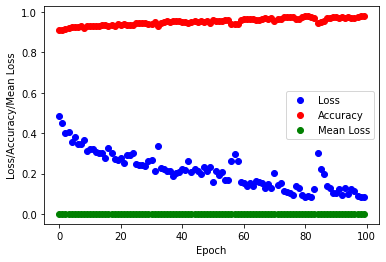

In [ ]:
# plot the loss and accuracy
for i in range(len(losses)):
    plt.plot(i, losses[i], 'bo')
    plt.plot(i, accuracies[i], 'ro')
    plt.plot(i, mean_losses[i], 'go')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy/Mean Loss')
    plt.legend(['Loss', 'Accuracy', 'Mean Loss'])

plt.show()

In [ ]:
# Train and test the model
loss_fn, optimizer = sgd_optimizer(model, lr=0.01)
epochs = 100
losses = []
accuracies = []
mean_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    
    loss = get_loss(test_dataloader, model, loss_fn)
    acc = get_score(test_dataloader, model, loss_fn)
    mean_loss = get_mean_loss(test_dataloader, model, loss_fn, optimizer)
    
    losses.append(loss)
    accuracies.append(acc)
    mean_losses.append(mean_loss)

print("Done!")

In [ ]:
# plot the loss and accuracy
for i in range(len(losses)):
    plt.plot(i, losses[i], 'bo')
    plt.plot(i, accuracies[i], 'ro')
    plt.plot(i, mean_losses[i], 'go')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy/Mean Loss')
    plt.legend(['Loss', 'Accuracy', 'Mean Loss'])

plt.show()

In [ ]:
# Train and test the model
loss_fn, optimizer = sgd_optimizer(model, lr=0.001)
epochs = 100
losses = []
accuracies = []
mean_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    
    loss = get_loss(test_dataloader, model, loss_fn)
    acc = get_score(test_dataloader, model, loss_fn)
    mean_loss = get_mean_loss(test_dataloader, model, loss_fn, optimizer)
    
    losses.append(loss)
    accuracies.append(acc)
    mean_losses.append(mean_loss)

print("Done!")

In [ ]:
# plot the loss and accuracy
for i in range(len(losses)):
    plt.plot(i, losses[i], 'bo')
    plt.plot(i, accuracies[i], 'ro')
    plt.plot(i, mean_losses[i], 'go')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy/Mean Loss')
    plt.legend(['Loss', 'Accuracy', 'Mean Loss'])

plt.show()

# Question 2: Proposal for Practical Applications (40%)
Look for a typical computer vision problem, such as:
a. removing noise on the image

b. increasing the resolution of the image

c. identifying objects in the image

d. segmenting the area to which the image belongs

e. estimating the depth of an object

f. estimating the motion of two object in different frames

h. others

Discuss possible applications of this problem in life, e.g. image editing systems in your phone, improved quality of the old film, sweeping robot avoiding obstacles, unlocks the face of the mobile phone, identifies the cancer area according to the medical scan image, determines the identity according to the face, identifies the trash can on the road, and the detection system tracks the target object, etc.

In this question, you need to do
1. Clearly define the problem and describe its application scenarios
2. Briefly describe a feasible solution based on image processing and traditional machine learning algorithms.
3. Briefly describe a feasible deep learning-based solution.
4. Compare the advantages and disadvantages of the two options.

Hint1: Submit an individua report for question 2.

Hint2: Well orginaze your report.

Hint3: You can draw flow chart or inculde other figures for better understanding of your solution.  

Please restrict your report within 800 words. In this question, you do not need to implement your solution. You only need to write down a proposal. Please submit this report in a seperate pdf. 

